In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from itertools import combinations
import time
from datetime import datetime
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [2]:
# import data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# shape and preview
print(f'Train data shape: {train.shape}')
print(f'Test data shape: {test.shape}')
train.head()

Train data shape: (26298, 6)
Test data shape: (6570, 5)


,row_id,date,country,store,product,num_sold
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26298 entries, 0 to 26297
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26298 non-null  int64 
 1   date      26298 non-null  object
 2   country   26298 non-null  object
 3   store     26298 non-null  object
 4   product   26298 non-null  object
 5   num_sold  26298 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [4]:
print(f'Missing values in train data: {train.isnull().sum().sum()}')
print(f'Missing values in test data: {test.isnull().sum().sum()}')

Missing values in train data: 0
Missing values in test data: 0


- The date feature is in international format but saved as string, we'll change these to date type.
- Country, store and product fetures are strings as well. We'll one-hot encode these to categorical numeric types.
- There isn't any missing data.

# Feature Cardinality

In [5]:
print(f'Training data: \n{train.nunique()}\n')
print(f'Test data: \n{test.nunique()}')

Training data: 
row_id      26298
date         1461
country         3
store           2
product         3
num_sold     1377
dtype: int64

Test data: 
row_id     6570
date        365
country       3
store         2
product       3
dtype: int64


Country, store, and product features have low cardinality, one hot encoding will suit these features. Let's check the date range, to get a glimpse of the timescale

In [6]:
# cast date column in both datasets
data = [train, test]
for d in data:
    d['date'] = pd.to_datetime(d['date'])

# get timeframe
print('Training data')
print(f'Min date: {train.date.min()}')
print(f'Max date: {train.date.max()}\n')
print('Test data')
print(f'Min date: {test.date.min()}')
print(f'Max date: {train.date.max()}')

Training data
Min date: 2015-01-01 00:00:00
Max date: 2018-12-31 00:00:00

Test data
Min date: 2019-01-01 00:00:00
Max date: 2018-12-31 00:00:00


The training data has data that spans 3 years, 2015-2018, while the test data has 1 year, 2019.

# Exploratory Data Analysis

In [7]:
train.pivot_table(values='num_sold', columns='store', index='date', aggfunc='sum')

store,KaggleMart,KaggleRama
date,,
2015-01-01,3916,6852
2015-01-02,3669,6329
2015-01-03,4057,7018
2015-01-04,4006,6721
2015-01-05,2880,4988
...,...,...
2018-12-27,4188,7367
2018-12-28,5506,9868
2018-12-29,7632,13629


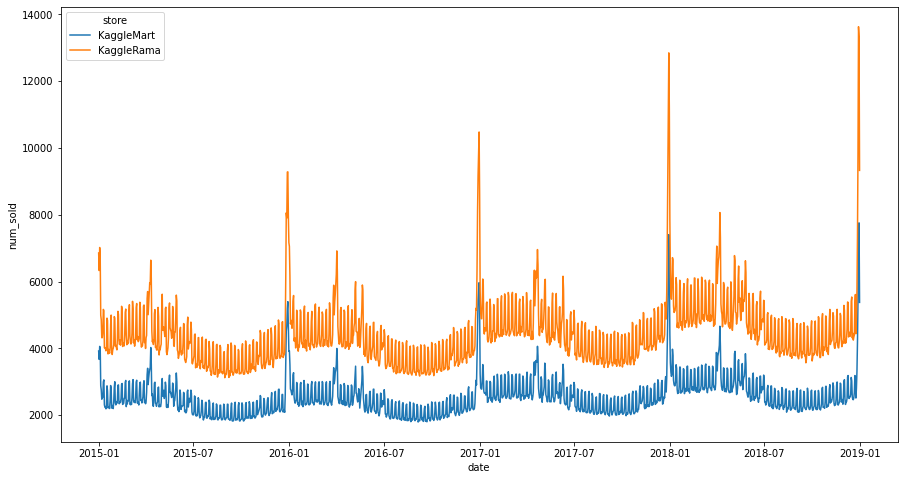

In [8]:
# store sales
plt.figure(figsize=(15,8))

df = train.groupby(['date', 'store']).agg(num_sold=('num_sold', 'sum'))

sns.lineplot(x='date', y='num_sold', hue='store', data=df)
plt.show()

- Kaggle Rama consistently sold more products.
- Products sold in both companies oscillate depending on time of year and flactuates rapidly.
- There are big spikes at the end/begining of every year, and other seasonal spikes.

## Store sales by country
Let's look at whether stores sell more products in specific countries.

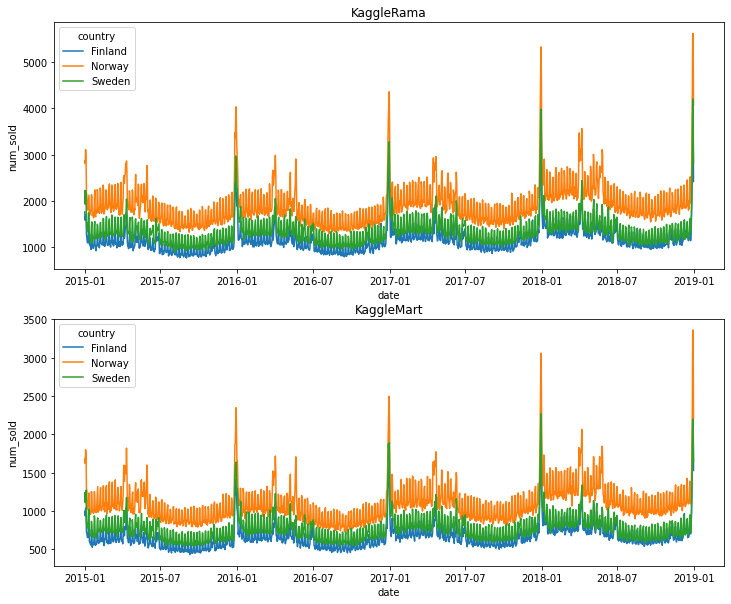

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# isolate store data
KaggleRama = train[train.store == 'KaggleRama']
KaggleMart = train[train.store == 'KaggleMart']
df_KR = KaggleRama.groupby(['date', 'country']).agg(num_sold=('num_sold', 'sum'))
df_KM = KaggleMart.groupby(['date', 'country']).agg(num_sold=('num_sold', 'sum'))

# lineplots
ax1 = sns.lineplot(ax=axes[0], x='date', y='num_sold', hue='country', data=df_KR)
ax2 = sns.lineplot(ax=axes[1], x='date', y='num_sold', hue='country', data=df_KM)

ax1.title.set_text('KaggleRama')
ax2.title.set_text('KaggleMart')

- Both stores sell most in Norway
- Sweden and Finland perform similarly, however Sweden has an edge over Finland.

## Store sales by product type

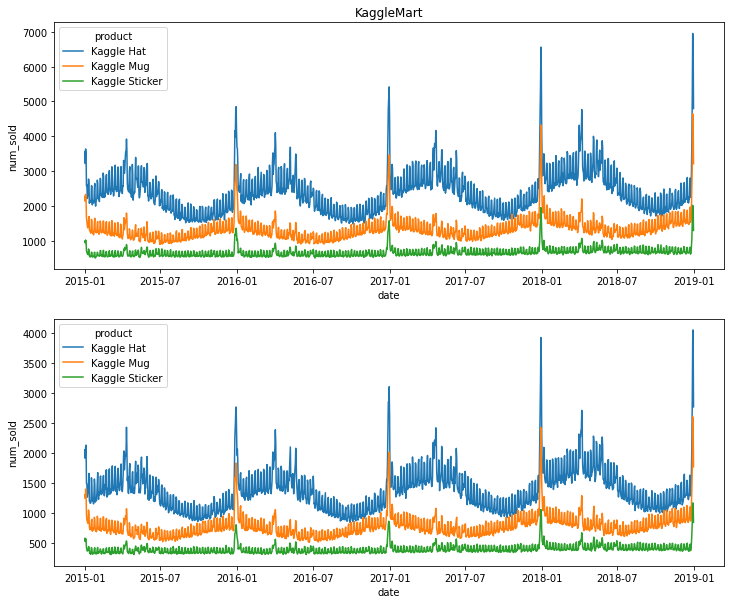

In [10]:
# subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# get product data in both stores
df_KM_prod = KaggleMart.groupby(['date', 'product']).agg(num_sold=('num_sold', 'sum'))
df_KR_prod = KaggleRama.groupby(['date', 'product']).agg(num_sold=('num_sold', 'sum'))

# lineplots
ax1 = sns.lineplot(ax=axes[0], x='date', y='num_sold', hue='product', data=df_KR_prod)
ax2 = sns.lineplot(ax=axes[1], x='date', y='num_sold', hue='product', data=df_KM_prod)

ax1.title.set_text('KaggleRama')
ax1.title.set_text('KaggleMart')

plt.show()

- Both stores sell hats the most, followed by mugs and stickers.
- Sticker sales are relatively constant throughout the year.
- Hat and mug sales seem to be affected by seasonality.

# Preprocessing and feature engineering

In [11]:
# labels and features
y = train.num_sold
X = train.drop('num_sold', axis=1)

## Public holidays

In [12]:
holidays_file = '../input/Holidays_Finland_Norway_Sweden_2015-2019.csv'

def GetHoliday(holidays_file, df):
    """
    Get a boolean feature of whether the current date is a holiday sale
    :param holiday_file:
    :param df:
    :return: dataframe
    """
    holidays = pd.read_csv(holidays_file)
    fin_holiday = holidays.loc[holidays.Country == 'Finland']
    swe_holiday = holidays.loc[holidays.Country == 'Sweden']
    nor_holiday = holidays.loc[holidays.Country == 'Norway']
    df['fin_holiday'] = df.data.isin(fin_holiday).astype(int)
    df['swe_holiday'] = df.data.isin(swe_holiday).astype(int)
    df['nor_holiday'] = df.data.isin(nor_holiday).astype(int)
    df['holiday'] = np.zeros(df.shape[0]).astype(int)

    df['holiday'] = np.zeros(df.shape[0]).astype(int)
    df.loc[df.country == 'Finland', 'holiday'] = df.loc[df.country == 'Finland', 'fin_holiday']
    df.loc[df.country == 'Sweden', 'holiday'] = df.loc[df.country == 'Sweden', 'swe_holiday']
    df.loc[df.country == 'Norway', 'holiday'] = df.loc[df.country == 'Norway', 'nor_holiday']
    df.drop(['fin_holiday', 'swe_holiday', 'nor_holiday'], axis=1, inplace=True)
    return df

### All holidays (including unofficial)

In [13]:
hol_file = '../input/holidays.csv'

def UnofficialHolidays(hol_file, df):
    """
    Get a boolean feature of whether the current date is a holiday sale
    :param hol_file: file with unofficial holidays
    :param df: dataframe
    :return: dataframe
    """
    countries = {'Finland': 1, 'Norway': 2, 'Sweden': 3}
    stores = {'KaggleMart': 1, 'KaggleRama': 2}
    products = {'Kaggle Mug': 1, 'Kaggle Hat': 2, 'Kaggle Sticker': 3}

    # load holiday info
    holiday = pd.read_csv(hol_file)

    fin_holiday = holiday.loc[holiday.country == 'Finland']
    swe_holiday = holiday.loc[holiday.country == 'Sweden']
    nor_holiday = holiday.loc[holiday.country == 'Norway']
    df['fin_holiday'] = df.date.isin(fin_holiday.date).astype(int)
    df['swe_holiday'] = df.date.isin(swe_holiday.date).astype(int)
    df['nor_holiday'] = df.date.isin(nor_holiday.date).astype(int)
    df['holiday'] = np.zeros(df.shape[0]).astype(int)
    df.loc[df.country == 'Finland', 'holiday'] == df.loc[df.country == 'Finland', 'fin_holiday']
    df.loc[df.country == 'Sweden', 'holiday'] = df.loc[df.country == 'Sweden', 'swe_holiday']
    df.loc[df.country == 'Norway', 'holiday'] = df.loc[df.country == 'Norway', 'nor_holiday']
    df.drop(['fin_holiday', 'swe_holiday', 'nor_holiday'], axis=1, inplace=True)
    return df

In [14]:
X = UnofficialHolidays(hol_file, X)
test = UnofficialHolidays(hol_file, test)

Let's include further date details: day of week, month, year

In [15]:
def date_eng(df):
    """
    Gets day of week, month, weekend, week number, month, and quarter
    :param df: dataframe
    :return: dataframe
    """
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day
    df['weekend'] = (df['day_of_week'] // 5 == 1)
    df['weekend'] = df['weekend'].astype('int')
    df['week'] = df['date'].dt.isocalendar().week
    df['week'][df['week'] > 52] = 52
    df['week'] = df['week'].astype('int')             # int64
    df['month'] = df['date'].dt.month                 # 1 to 12
    df['quarter'] = df['date'].dt.quarter             # 1 to 4
    df['year'] = df['date'].dt.year                   # 2015 to 2019
    return df

In [16]:
X = date_eng(X)
test = date_eng(test)

And now to add GDP info

Text(0.5, 1.0, 'Heatmap of GDP in nordic countries')

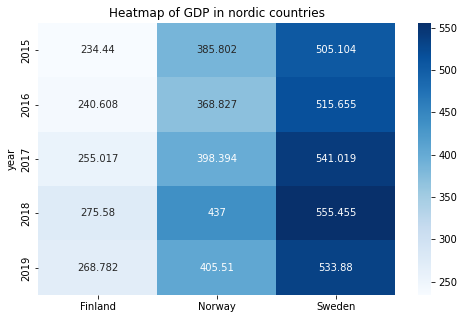

In [17]:
# Load data
GDP_data = pd.read_csv("../input/GDP_data_2015_to_2019_Finland_Norway_Sweden.csv",index_col="year")

# Rename the columns in GDP df
GDP_data.columns = ['Finland', 'Norway', 'Sweden']

# Plot data
plt.figure(figsize=(8,5))

# Heatmap with annotations
sns.heatmap(GDP_data, annot=True, fmt='g', cmap='Blues')

# Aesthetics
plt.title('Heatmap of GDP in nordic countries')

- The GDP in 2019 is lower than in 2018. This could suggest that we'll see lower sales in the test set. Hmmm.. We'll see!!

In [18]:
GDP_dictionary = GDP_data.unstack().to_dict()

# create GDP column
X['GDP'] = X.set_index(['country', 'year']).index.map(GDP_dictionary.get)
test['GDP'] = test.set_index(['country', 'year']).index.map(GDP_dictionary.get)

## GDP per capita

In [19]:
# Load data
GDP_PC=pd.read_csv('../input/GDP_per_capita_2015_to_2019_Finland_Norway_Sweden.csv',index_col="year")

# Create a dictionary
GDP_PC_dictionary = GDP_PC.unstack().to_dict()

# Create new GDP_PC column
X['GDP_PC'] = X.set_index(['country', 'year']).index.map(GDP_PC_dictionary.get)
test['GDP_PC'] = test.set_index(['country', 'year']).index.map(GDP_PC_dictionary.get)

# Preview df
X.head()

,row_id,date,country,store,product,holiday,day_of_week,day_of_month,weekend,week,month,quarter,year,GDP,GDP_PC
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,0,3,1,0,1,1,1,2015,234.44,42802
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,0,3,1,0,1,1,1,2015,234.44,42802
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,0,3,1,0,1,1,1,2015,234.44,42802
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,0,3,1,0,1,1,1,2015,234.44,42802
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,0,3,1,0,1,1,1,2015,234.44,42802


In [20]:
import math

def FourierFeatures(df):
    for product in ['Kaggle Mug', 'Kaggle Hat']:
        df[product] = df['product'] == product
    dayofyear = df.date.dt.dayofyear
    for k in range(1, 3):
        df[f'sin{k}'] = np.sin(dayofyear / 365 * 2 * math.pi * k)
        df[f'cos{k}'] = np.cos(dayofyear / 365 * 2 * math.pi * k)
        df[f'mug_sin{k}'] = df[f'sin{k}'] * df['Kaggle Mug']
        df[f'mug_cos{k}'] = df[f'cos{k}'] * df['Kaggle Mug']
        df[f'hat_sin{k}'] = df[f'sin{k}'] * df['Kaggle Hat']
        df[f'hat_cos{k}'] = df[f'cos{k}'] * df['Kaggle Hat']
        df=df.drop([f'sin{k}', f'cos{k}'], axis=1)
    df = df.drop(['Kaggle Mug', 'Kaggle Hat'], axis=1)
    return df

X = FourierFeatures(X)
test = FourierFeatures(test)

In [21]:
# drop date
X.drop('date', axis=1, inplace=True)
test.drop('date', axis=1, inplace=True)

# encode categorical features
X=pd.get_dummies(X, columns=['store', 'country', 'product'])
test=pd.get_dummies(test, columns=['store', 'country', 'product'])

# Modelling